In [58]:
import open3d as o3d
import numpy as np
import cv2

In [266]:
test_stl_obj_path = "../data/output/01372_mk19/character_xyz/stl/3.stl"

In [267]:
test_obj = o3d.io.read_triangle_mesh(test_stl_obj_path)

In [268]:
bbox_max = test_obj.get_max_bound()

In [269]:
test_obj.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-4.82738, -4.6069, -1.20315), max: (4.28448, 4.59236, 0.710061)

In [270]:
bbox_min = test_obj.get_min_bound()

In [271]:
scale_ratio = 1 / max(bbox_max - bbox_min)

In [272]:
scale_ratio

0.1087043479365165

In [273]:
scaled_test_obj = test_obj.scale(scale_ratio, center=np.zeros((3, 1)))

In [274]:
scaled_test_obj.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-0.524758, -0.50079, -0.130787), max: (0.465741, 0.49921, 0.0771867)

In [275]:
scaled_bbox_min = scaled_test_obj.get_min_bound()
scaled_bbox_max = scaled_test_obj.get_max_bound()

In [276]:
translated_scaled_test_obj = scaled_test_obj.translate((scaled_bbox_max + scaled_bbox_min)/2)

In [277]:
translated_scaled_test_obj.get_axis_aligned_bounding_box()

AxisAlignedBoundingBox: min: (-0.554266, -0.50158, -0.157588), max: (0.436233, 0.49842, 0.0503863)

In [278]:
pc_points = o3d.geometry.TriangleMesh.compute_triangle_normals(translated_scaled_test_obj)
pc_points.remove_duplicated_vertices()
o3d.io.write_triangle_mesh('test_norm_character.stl', pc_points)

True

In [279]:
from copy import deepcopy

In [280]:
def scale_to_z(a, min_depth, max_depth, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-z_scale
        Optionally specify the data type of the output (default is uint16)
    """
    bg_mask = np.full(a.shape, 1) # 255)
    img = deepcopy(a) # (((a - min_depth) / float(max_depth - min_depth)) * 254)
    
    depth_img = np.where(a == np.inf, bg_mask, img)
    return depth_img.astype(dtype)

In [281]:
def ray_tracing_fix_depth_map(pc_mesh, side_range=(-12, 12), fwd_range=(-12, 12), res=(2000, 2000, 255), z_max_camera=10,
                          max_z_distance=16):
    t_pc_mesh = o3d.t.geometry.TriangleMesh.from_legacy(pc_mesh)
    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(t_pc_mesh)
    side_width = side_range[1] - side_range[0]
    fwd_height = fwd_range[1] - fwd_range[0]
    ratio_width = side_width / res[0]
    ratio_height = fwd_height / res[1]
    x_range = side_range[0] + np.arange(res[0]) * ratio_width
    y_range = fwd_range[1] - np.arange(res[1]) * ratio_height
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    x_mesh_flat = x_mesh.reshape((-1,))
    y_mesh_flat = y_mesh.reshape((-1,))
    z_mesh_flat = np.full((x_mesh_flat.shape[0],), z_max_camera)
    direction = np.repeat(np.asarray([0, 0, -1]).reshape((1, -1)), z_mesh_flat.shape[0], axis=0)
    point_mesh = np.stack((x_mesh_flat, y_mesh_flat, z_mesh_flat), axis=1)
    rays = np.concatenate((point_mesh, direction), axis=1)
    rays = o3d.core.Tensor(rays, dtype=o3d.core.Dtype.Float32)
    ans = scene.cast_rays(rays, nthreads=8)
    pixel_values = ans['t_hit'].numpy()
    pixel_values = pixel_values.reshape((res[0], res[1]))

    normalized_pixel_values = scale_to_z(pixel_values, 0, 1, dtype=np.float)
    img_inverted_matrix = np.array([[ratio_width, 0, 0, side_range[0]], [0, -ratio_height, 0, fwd_range[1]],
                                    [0, 0, -max_z_distance / 254.0, z_max_camera], [0, 0, 0, 1]])
    return img_inverted_matrix, normalized_pixel_values

In [282]:
def convert_normalized_pc_to_depth_map(stl_path, res=(256, 256, 255)):
    """
    Main function to convert the .stl model into depth map images.
    :param stl_path: 3D triangle_mesh object or the file path string
    :param res: the resolution of output depth map image
    :return:
        + normalized_depth_img: depth image with the input resolution.
        Because the camera position is at z_max + 0.5, so [0, 254] range in images: expresses distance [z_max + 0.5, z_min + 0.5].
        Value 255 expresses the infinity
        + img_inverted_matrix: the matrix will be used when you want to get back almost point cloud model from depth map (can not convert back completely) through matrix multi.
    """
    if isinstance(stl_path, str):
        pc_mesh = o3d.io.read_triangle_mesh(stl_path)
    else:
        pc_mesh = stl_path
    img_inverted_matrix, normalized_depth_img = ray_tracing_fix_depth_map(pc_mesh, side_range=(-0.5, 0.5), fwd_range=(-0.5, 0.5),
                                                                      res=res,
                                                                      z_max_camera=0.5,
                                                                      max_z_distance=1)
    return img_inverted_matrix, normalized_depth_img

In [283]:
_, depth_img = convert_normalized_pc_to_depth_map(pc_points)

In [284]:
with open("depth_img.npy", "wb") as f:
    np.save(f, depth_img)

In [285]:
cv2.imwrite('depth_img.png', depth_img)

True

In [286]:
import matplotlib.pyplot as plt

In [287]:
i_depth_img = cv2.imread('depth_img.png')

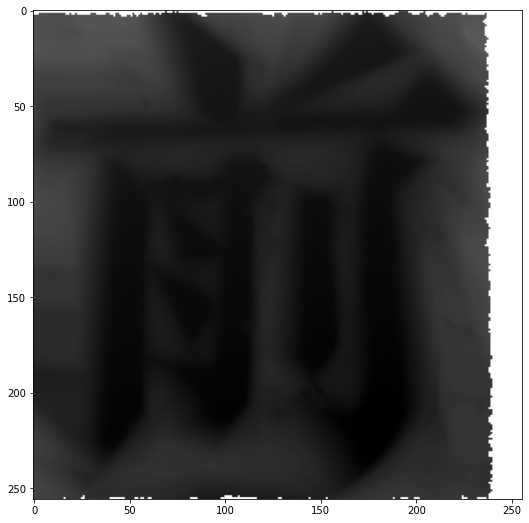

In [288]:
plt.figure(figsize=(12, 9))
plt.imshow(depth_img, cmap='gray')

In [289]:
import json
import os

In [290]:
def read_json_file(json_path):
    with open(json_path, 'r') as f:
        content = json.load(f)
    return content

def parse_bboxes_list_from_sino_nom_anno_file(sino_nom_file):
    anno_info = read_json_file(sino_nom_file)
    bboxes_info = anno_info["bboxes"]
    bboxes_list = []
    for bbox in bboxes_info:
        x_min, y_min, x_max, y_max = bbox["x_min"], bbox["y_min"], bbox["x_max"], bbox["y_max"]
        rect_box_points = np.asarray([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
        bboxes_list.append(rect_box_points)
    return bboxes_list

In [322]:
def crop_2d_img(img, pts, tgt_size):
    pts = np.array(pts, dtype=np.int32)
    rect = cv2.boundingRect(pts)
    x, y, w, h = rect
    scale_ratio = tgt_size / max(w, h)
    croped = img[y:y+h, x:x+w].copy()
    croped = cv2.resize(croped, (round(w*scale_ratio), round(h*scale_ratio)), interpolation = cv2.INTER_AREA)
    w, h = round(w*scale_ratio), round(h*scale_ratio)
    # print(w, h)
    bg_center = (tgt_size//2, tgt_size//2)
    bg_img = np.full((tgt_size, tgt_size, 3), 0)
    t_l_x, t_l_y = bg_center[0] - w // 2, bg_center[1] - h // 2
    bg_img[t_l_y: t_l_y + h, t_l_x: t_l_x + w, :] = croped
    return bg_img

In [323]:
print_img_path = "/mnt/hdd/thuonglc/mocban/woodblock-gt-depth-gen/data/raw/01372_mk19/nb_aligned_01372_mk19.png"
sino_nom_path = "/mnt/hdd/thuonglc/mocban/woodblock-gt-depth-gen/data/raw/01372_mk19/nb_aligned_01372_mk19.json"

In [324]:
bboxes_2d_list = parse_bboxes_list_from_sino_nom_anno_file(sino_nom_path)

In [325]:
print_img = cv2.imread(print_img_path)
for s_index, bbox in enumerate(bboxes_2d_list):
    character_img = crop_2d_img(print_img, bbox, 256)
    cv2.imwrite(str(os.path.join('temp', f'{s_index}.png')), character_img)

In [326]:
print_img = cv2.imread("./temp/3.png")

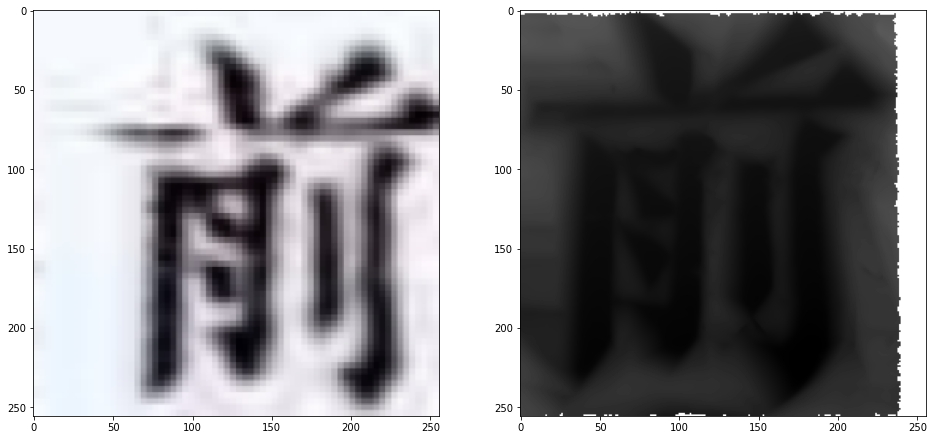

In [327]:
fig, axes =  plt.subplots(nrows=1, ncols=2, figsize=(16, 12))
axes[0].imshow(print_img);
axes[1].imshow(depth_img, cmap='gray');